# CODE: Code for Optimizing Docking Enrichments

In [1]:
######Importa los paquetes necesarios
%pylab inline
import csv
import os
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import optimize
from __future__ import division
from random import sample
import pdb
set_printoptions(threshold='nan')

Populating the interactive namespace from numpy and matplotlib


In [161]:
###IMPORTANTE EL ORDEN DE LAS COLUMNAS EN EL ARCHIVO CSV.
###PRIMER DEBEN IR LAS COLUMNAS SIN IMPORTANCIA Y LA COLUMNA "ACTIVE (BOOLEAN)"
###SEGUNDO DEBEN IR LAS COLUMNAS CON LAS VARIABLES A OPTIMIZAR
###TERCERO DEBE HABER UNA COLUMNA CON VALORES CUALQUIERA (TOMARA LOS VALORES DE CODE)

#Importa la info pero se salta la primera fila (titulos y cosas sin importancia)
Datos=genfromtxt("TrainingSetScript.csv", delimiter=',', skip_header=1)  
pesot=3
threshold=30
ordcolu=10
actcolu=2
iterat=20
numparam=6
trainum=50
seed=0
DatosTrain=zeros((trainum, len(Datos[0,:])))
DatosTest=zeros((len(Datos[:,0])-trainum, len(Datos[0,:])))
indxTrain=[]
indxTest=[]
coeficientes=[]
DatosFin=[]
#Col 0: Nombre
#Col 1: Active (String)
#Col 2: Active (Boolean)
#Col 3: logP
#Col 4: DockingScore
#Col 5: MM-GBSA
#Col 6: DockingScore-BOB
#Col 7: MM-GBSA-BOB
#Col 8: Delta E
#Col 9: CODE

#Para que Ordenador funcione es necesario que los inactivos tengan un valor mas alto que los
#activos
for i in range (0, len(Datos[:,0])):
    if Datos[i,actcolu]==0:
        Datos[i,actcolu]=2
        
#Toma el minimo valor de las columnas involucradas en CODE y divide todos los valores de la 
#columna en ese numero (normaliza las propiedades manteniendo signo negativo)
ignorar=len(Datos[0,:])-numparam-1
for j in range (ignorar, len(Datos[0,:])-1):
    minimo=min(Datos[:,j])
    maximo=max(Datos[:,j])
    if abs(minimo)>abs(maximo):
        norm=minimo
    if abs(minimo)<=abs(maximo):
        norm=maximo
    for k in range (0, len(Datos[:,0])):
        Datos[k,j]=Datos[k,j]/abs(norm)

        
for l in range (0, trainum):
    random.seed(seed+l)
    indxTrain.append(randint(0, len(Datos[:,0])))
for m in range (0, trainum):
    idx=indxTrain[m]
    for n in range(0, len(Datos[0,:])):
        DatosTrain[m,n]=Datos[idx,n]

        
for o in range (0, len(Datos[:,0])):
    if ((o in indxTrain)==False):
        indxTest.append(o)
ind=0
for p in range(0, len(Datos[:,0])):
    if ((p in indxTest)==True and ind <95):
        DatosTest[ind,:]=Datos[p,:]
        ind +=1

print indxTrain
print indxTest
print DatosTrain
print DatosTest
print len(Datos[:,0]), len(DatosTrain[:,0]), len(DatosTest[:,0])


[47, 37, 15, 106, 122, 99, 138, 25, 84, 126, 9, 80, 75, 82, 107, 140, 121, 111, 42, 93, 99, 56, 117, 83, 131, 132, 53, 19, 1, 115, 37, 87, 43, 20, 122, 15, 133, 143, 75, 137, 70, 140, 102, 68, 20, 131, 69, 135, 0, 114]
[2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 44, 45, 46, 48, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 71, 72, 73, 74, 76, 77, 78, 79, 81, 85, 86, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 100, 101, 103, 104, 105, 108, 109, 110, 112, 113, 116, 118, 119, 120, 123, 124, 125, 127, 128, 129, 130, 134, 136, 139, 141, 142, 144]
[[  3.46000000e+00              nan   1.00000000e+00   2.50000000e-01
    7.34857366e-01  -8.43779904e-01  -5.71759599e-01  -7.65425236e-01
   -5.12841616e-01  -1.53970367e-01   0.00000000e+00]
 [  3.38000000e+00              nan   1.00000000e+00   2.50000000e-01
    9.05041032e-01  -8.27153110e-01  -9.70688898e-01  -8.03001668e-01
   -6.46378743

In [156]:
#Devuelve el array 'array' ordenado de menor a mayor segun los valores de la columna 'numcol'
def Ordenador(array, numcol):
    
    Ordered=array[array[:,numcol].argsort()]
    
    return Ordered

In [937]:
#Devuelve un array 1 x n con el porcentaje de compuestos screened que se tienen a medida que
#se recorre un compuesto en 'arrayord' a la vez. 'arrayord' no tiene que estar ordenado.
def CompScreened(arrayord):
    
    comptot = len(arrayord[:,0])
    compscreen=[]
    index=1
    
    for i in range(0, len(arrayord[:, 0])):
        comppercent = index/comptot * 100
        compscreen.append(comppercent)
        index += 1
        
    return compscreen

In [938]:
#Devuelve un array 1 x n con el porcentaje de activos encontrados a medida que se recorre un
#compuesto en 'arrayord' a la vez.
def ActScreened(arrayord, actcol):
    
    acttot=0
    actfound=0
    actscreen=[]
    
    for h in range(0, len(arrayord[:, 0])):
        if (arrayord[h,actcol] == 1): #Aca se busca el 1 en la columna 'actcol'
            acttot += 1
            
    for i in range(0, len(arrayord[:,0])):
        if (arrayord[i, actcol] == 1):
            actfound += 1
        actpercent = actfound/acttot * 100
        actscreen.append(actpercent)
        
    return actscreen

In [939]:
#Calcula la pendiente promedio de la curva de enriquecimiento obtenida a partir del array ya
#ordenado segun lo que se quiera, 'arrayord'. Llama a Actscreened entonces necesita saber donde
#esta la columna de actividad booleana 'actcol'
def pendfunc(arrayord, actcol, peso, thres):
    
    compscreen=CompScreened(arrayord)
    actscreen=ActScreened(arrayord, actcol)
    val=0
    pend=[]
    
    for i in range(0, len(compscreen)-1):
        if actscreen[i]<100:
            val=(actscreen[i+1]-actscreen[i])/(compscreen[i+1]-compscreen[i])
            pend.append(val)
            if compscreen[i]<=thres:
                for j in range(0, peso):
                    pend.append(val)
                    
    pendiente=average(pend)
    
    return pendiente*-1 #Devuelve el negativo para que toque minimizar, no maximizar

In [940]:
#Pone en la ultima columna del array 'array', el valor de la funcion CODE para cada fila.
#La funcion CODE es el producto punto del array 'param' y las ultimas columnas de cada fila, 
#sin incluir la ultima porque ahi va el nuevo valor
def CODEfunc(array, param):
    
    igncol=len(array[0,:])-len(param)-1
    
    for i in range(0,len(array[:,0])):
        CODE=0
        for j in range(0, len(param)):
            CODE += param[j]*array[i,j+igncol]
        array[i, len(array[0,:])-1]=CODE
        
    return array

In [941]:
#Agrega la columna CODE al array 'array'. CODE es calculada segun los parametros 'param'.
#Ordena 'array' segun el valor de CODE y devuelve la pendiente de la curva de enriquecimiento.
#Llama ActScreened entonces necesita saber la posicion 'actcol' donde esta la actividad 
#booleana
def CODEordpend(param, array, actcol):
    
    CODEarray=CODEfunc(array, param)
    Orderedarray=Ordenador(CODEarray, len(CODEarray[0,:])-1)
    final=pendfunc(Orderedarray, actcol, pesot, threshold)
    
    return final

In [942]:
#Igual a la funcion FINAL excepto que solo toma el array de parametros 'param'. El array usado
#es DatosIni y la columna donde esta la actividad booleana es 2. Esto toca editarlo manualmente
#si se va a usar otro caso modelo
def CODEordpend2(param):
    
    CODEarray=CODEfunc(DatosIni, param)
    Orderedarray=Ordenador(CODEarray, len(CODEarray[0,:])-1)
    final=pendfunc(Orderedarray, actcolu, pesot, threshold)
    
    return final

In [943]:
def rCODE(array, actcol, peso, thres):
    actual=pendfunc(Ordenador(array, len(DatosIni[0,:])-1), actcol, peso, thres)
    ideal=pendfunc(Ordenador(array, actcol), actcol, peso, thres)
    rcode = actual/ideal
    return rcode

In [944]:
#Genera un numero 'iter' de arrays de 5 elementos (numero de parametros) y partir de cada uno
#minimiza el negativo de la pendiente. Devuelve los parametros que otorgan la minima pendiente 
#negativa
def minimizacion(itera):
    
    val=[]
    minglob=0
    minloc=0
    
    for i in range (0, itera):
        guess=random.sample((numparam))
        res=optimize.minimize(CODEordpend2, guess, method='Nelder-mead')#, options={'disp':True})
        minloc=CODEordpend2(res.x)
        if (i%5==0):
            print i
        if (minloc<minglob):
            print 'Se encontro un mejor minimo en el paso: ' + str(i)
            minglob=minloc
            val=res.x
    return val

In [945]:
coeficientes=minimizacion(10)
DatosFin=CODEfunc(DatosIni, coeficientes)

0
Se encontro un mejor minimo en el paso: 0
Se encontro un mejor minimo en el paso: 1
5
Se encontro un mejor minimo en el paso: 8


Los mejores parametros son: [0.0767693, 0.28976293, 0.06743755, 0.36608458, 0.81722647]
Con los mejores parametros se obtiene una pendiente ponderada de: 1.23127195127
Con los mejores parametros se obtiene una funcion r-CODE de: 0.70479704797
Recuerde que r-CODE puede tomar valores entre 1.0 (Ideal) y 0.572413793103 (Aleatorio) 


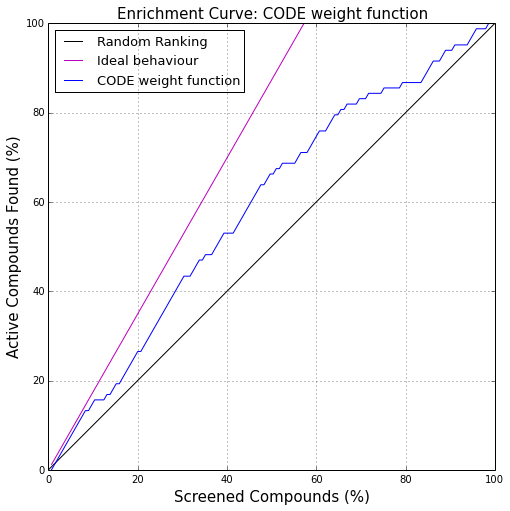

In [946]:
def resultados(coefi, array, actcol, peso, thres):
    print 'Los mejores parametros son: ' + str(coefi)
    print 'Con los mejores parametros se obtiene una pendiente ponderada de: ' + str(-1*CODEordpend2(coefi))
    print 'Con los mejores parametros se obtiene una funcion r-CODE de: ' + str(rCODE(DatosFin, actcolu, pesot, threshold))
    print 'Recuerde que r-CODE puede tomar valores entre 1.0 (Ideal) y ' + str(-1/pendfunc(Ordenador(array, actcol), actcol, peso, thres)) + ' (Aleatorio) '
    
    figure(figsize=(8,8)); hold(True)
    p=arange(0,101,1)
    lin=p
    plot(p,lin, 'k-', lw=1, label=r'Random Ranking')

    plot(CompScreened(DatosIni), ActScreened(Ordenador(DatosIni, actcolu), actcolu), 'm-', lw=1, label=r'Ideal behaviour')
    plot(CompScreened(DatosIni), ActScreened(Ordenador(DatosFin, len(DatosIni[0,:])-1), actcolu), 'b-', lw=1, label=r'CODE weight function')

    title(r'Enrichment Curve: CODE weight function', fontsize=15)
    xlabel(r'Screened Compounds (%)', fontsize=15)
    ylabel(r'Active Compounds Found (%)', fontsize=15)
    legend(fontsize=13, loc=2)
    grid()
    savefig('./CurvaCODE.pdf')
    show()
resultados(coef, DatosIni, actcolu, pesot, threshold)

In [875]:
coef=[0.0767693, 0.28976293,  0.06743755,  0.36608458,  0.81722647]
print coef

[0.0767693, 0.28976293, 0.06743755, 0.36608458, 0.81722647]
